In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mglearn.plots

In [110]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [112]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Split the data

In [113]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(data.drop('Outcome', axis=1), data['Outcome'], random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=0)

print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

Size of training set: 432   size of validation set: 144   size of test set: 192



In [114]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': range(1, 10),
              'min_samples_split': range(2, 10),
              'min_samples_leaf': range(1, 10)}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=5, return_train_score=True, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 8}


# Rebuild the model with the best parameters

In [115]:
tree = DecisionTreeClassifier(max_depth=grid_search.best_params_['max_depth'],
                              min_samples_split=grid_search.best_params_['min_samples_split'],
                              min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                              random_state=0)
tree.fit(X_trainval, y_trainval)

DecisionTreeClassifier(max_depth=6, min_samples_split=8, random_state=0)

# Evaluate the model

In [116]:
from sklearn.metrics import classification_report, confusion_matrix, auc

print(classification_report(y_test, tree.predict(X_test), target_names=['No Diabetes', 'Diabetes']))
print(confusion_matrix(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

 No Diabetes       0.79      0.87      0.83       130
    Diabetes       0.65      0.52      0.58        62

    accuracy                           0.76       192
   macro avg       0.72      0.69      0.70       192
weighted avg       0.75      0.76      0.75       192

[[113  17]
 [ 30  32]]


In [117]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="single_tree.dot", class_names=["malignant", "benign"], impurity=False, filled=True, feature_names=data.columns[:-1])

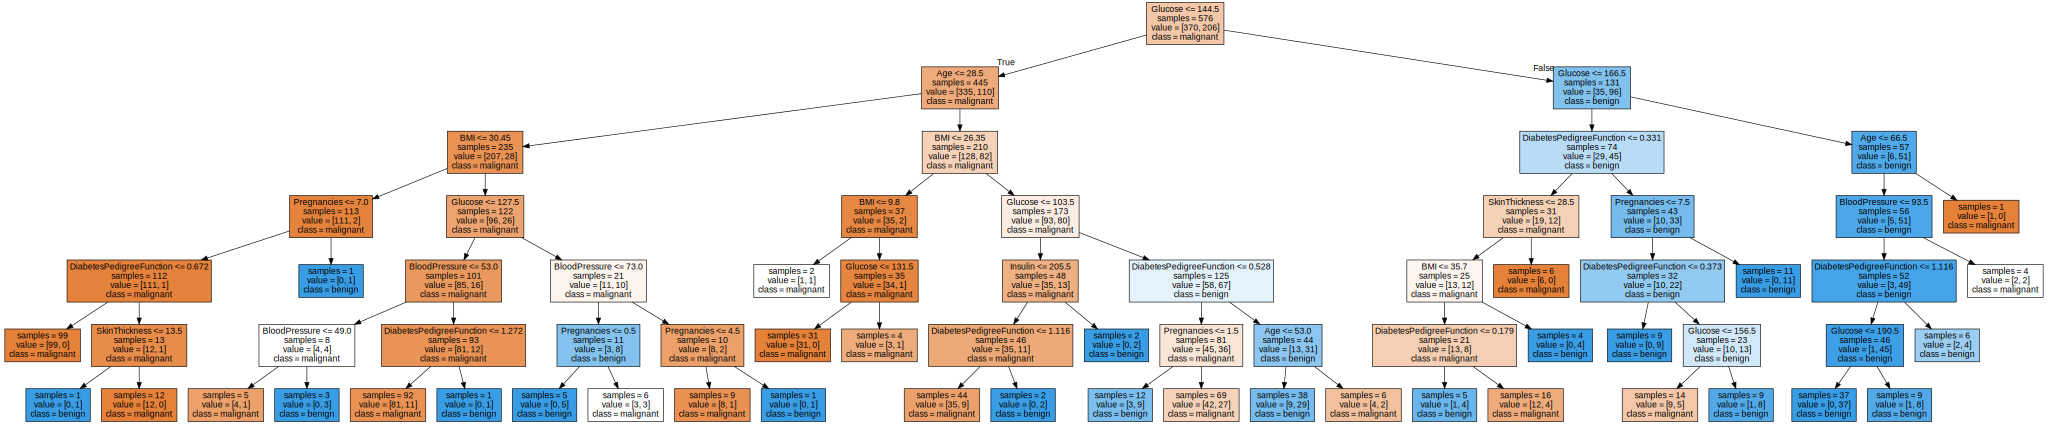

In [118]:
import graphviz

with open("single_tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

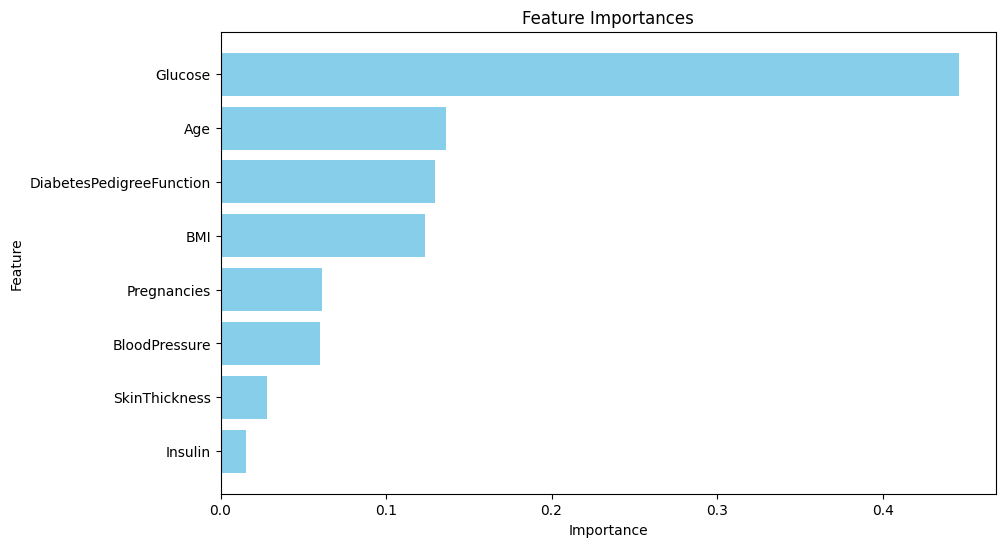

In [119]:
feature_importances = tree.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis() 
plt.show()


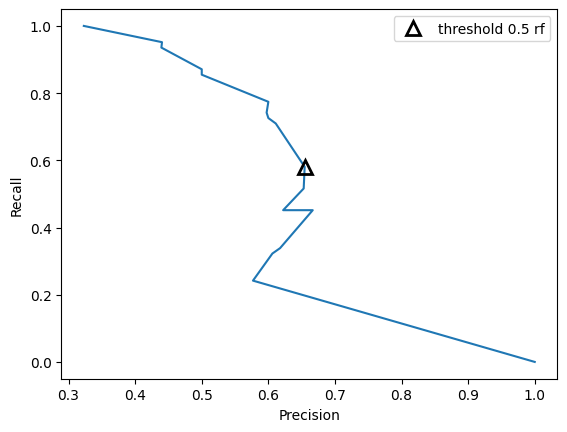

In [120]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, tree.predict_proba(X_test)[:, 1])

plt.plot(precision, recall)

close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_default], recall[close_default], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

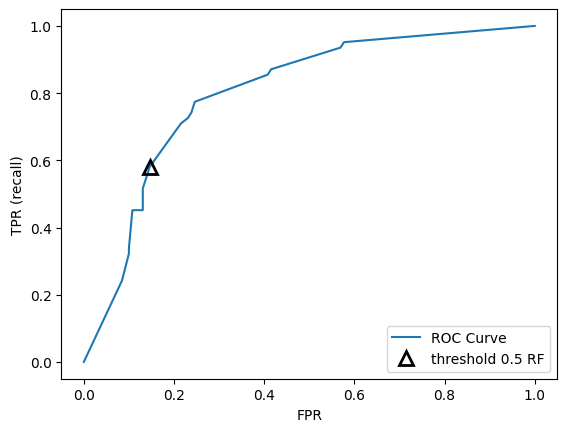

In [121]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_default], tpr[close_default], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

# Remove the least important features

In [122]:
print(importance_df.iloc[4:]['Feature'])

0      Pregnancies
2    BloodPressure
3    SkinThickness
4          Insulin
Name: Feature, dtype: object


In [123]:
X_test_less = X_test.drop(importance_df['Feature'].iloc[4:], axis=1)
X_trainval_less = X_trainval.drop(importance_df['Feature'].iloc[4:], axis=1)

In [124]:
X_trainval.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
762,9,89,62,0,0,22.5,0.142,33
127,1,118,58,36,94,33.3,0.261,23
564,0,91,80,0,0,32.4,0.601,27
375,12,140,82,43,325,39.2,0.528,58
663,9,145,80,46,130,37.9,0.637,40


In [125]:
tree_lessFeatures = DecisionTreeClassifier(max_depth=grid_search.best_params_['max_depth'],
                              min_samples_split=grid_search.best_params_['min_samples_split'],
                              min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                              random_state=0)

tree_lessFeatures.fit(X_trainval_less, y_trainval)

DecisionTreeClassifier(max_depth=6, min_samples_split=8, random_state=0)

In [126]:
print(classification_report(y_test, tree_lessFeatures.predict(X_test_less), target_names=['No Diabetes', 'Diabetes']))
print(confusion_matrix(y_test, tree_lessFeatures.predict(X_test_less)))

              precision    recall  f1-score   support

 No Diabetes       0.79      0.92      0.85       130
    Diabetes       0.74      0.50      0.60        62

    accuracy                           0.78       192
   macro avg       0.77      0.71      0.72       192
weighted avg       0.78      0.78      0.77       192

[[119  11]
 [ 31  31]]


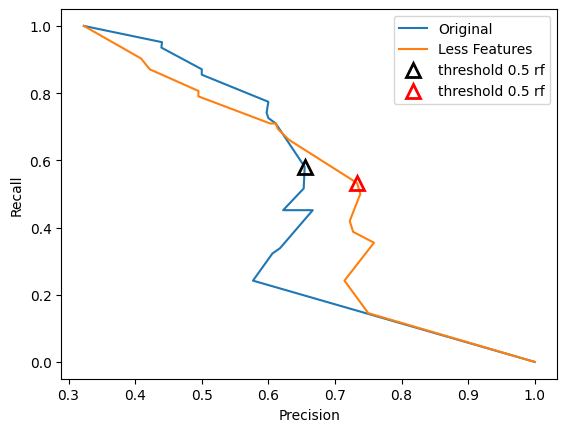

In [128]:
precision, recall, thresholds = precision_recall_curve(y_test, tree.predict_proba(X_test)[:, 1])
precision_lessFeatures, recall_lessFeatures, thresholds_lessFeatures = precision_recall_curve(y_test, tree_lessFeatures.predict_proba(X_test_less)[:, 1])


plt.plot(precision, recall, label='Original')
plt.plot(precision_lessFeatures, recall_lessFeatures, label='Less Features')

close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_default], recall[close_default], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)

close_default_lessFeatures = np.argmin(np.abs(thresholds_lessFeatures - 0.5))
plt.plot(precision_lessFeatures[close_default_lessFeatures], recall_lessFeatures[close_default_lessFeatures], '^', c='r',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

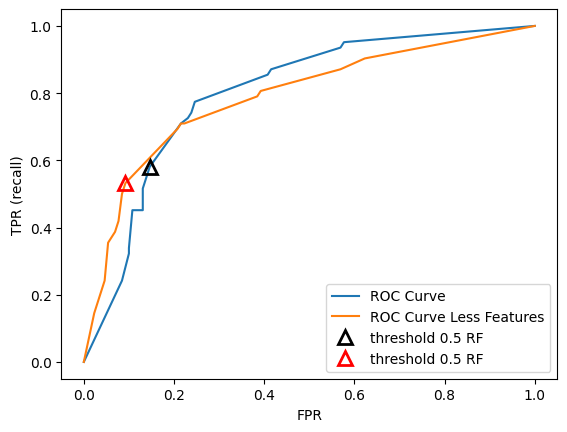

In [130]:
fpr_lessFeatures, tpr_lessFeatures, thresholds_lessFeatures = roc_curve(y_test, tree_lessFeatures.predict_proba(X_test_less)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve")
plt.plot(fpr_lessFeatures, tpr_lessFeatures, label="ROC Curve Less Features")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_default], tpr[close_default], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

close_zero_lessFeatures = np.argmin(np.abs(thresholds_lessFeatures))
close_default_lessFeatures = np.argmin(np.abs(thresholds_lessFeatures - 0.5))
plt.plot(fpr_lessFeatures[close_default_lessFeatures], tpr_lessFeatures[close_default_lessFeatures], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='r', mew=2)

plt.legend(loc=4)